### Mounting Google drive to read dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Paths to be defined here

In [ ]:
'''
Declare all paths which are used to trian and save
'''
# Path to saved dataset which is already split
dataset_path = '/content/drive/MyDrive/Master_Project/Dataset/processed_data.npz'
# Path to the save encoder models
deblur_path = "/content/drive/MyDrive/Master_Project/Dataset/deblur_encoder.h5"
denoise_path = "/content/drive/MyDrive/Master_Project/Dataset/denoise_encoder.h5"
# Path where all images during the process are saved
save_images = "/content/drive/MyDrive/Master_Project/images"
# Specify the path to save the processed dataset or the real world dataset which contains training, testing and validation
real_world_dataset_path = '/content/drive/MyDrive/Master_Project/Dataset/real_world_data.npz'
# Path for best model which is saved
best_cnn_model_path = "/content/drive/MyDrive/Master_Project/Models/"

### Constants

In [ ]:
# After surveying different papers we found that MRI images approx contain 15% of test noise
varying_noisy_data_amount = 0.15

### All Major imports

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime

import cv2
import os
import io

### Loading saved data set from numpy saved file

In [ ]:
#Load to start the work.
#Load the datasets
import numpy as np

data = np.load(dataset_path)

# Extracting the datasets
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']
x_val = data['x_val']
y_val = data['y_val']

### Function to simulate real world dataset

In [ ]:
'''
Take the input as dataset and perctange of images to be processed and noise factor that needs to be added on the image

funnction adds blur first and later noise to the image

returns images which have blur and noise
'''
def preprocess_image(image, scale_percent=20, noise_factor=0.15):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    small_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    width = int(small_image.shape[1] * (100 / scale_percent))
    height = int(small_image.shape[0] * (100 / scale_percent))
    dim = (width, height)
    pixelated_image = cv2.resize(small_image, dim, interpolation=cv2.INTER_LINEAR)
    noisy_image = pixelated_image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=pixelated_image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.).astype(np.uint8)
    return noisy_image

In [ ]:
'''
Take the input as image and scale image need to be reduced to add blur

Funciton resizes the image by the scale percentage specified
and resizes back to orginal size making the image blur and size of image is constant

returns images with blur
'''


def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image

In [ ]:
'''
Take the input as image and noise factor which defines the percentage of white noise and blur scale

Function adds white noise layer to the image and returns an image which has both noise and blur

returns images with noise an blur
'''

def pre_data(input_images, noise_factor = 0.15, scale_percent = 20):
  #Step2: Adding white noise
  input_image = input_images + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = input_images.shape)
  input_image = np.clip(input_image, 0., 1.)
  input_image = pixalate_image(input_image)
  return input_image

In [ ]:
'''
Function uses above pre_data to send one image at a time and save the preprocessed datata
returns the realworld data
'''

def preprocess_dataset(images, scale_percent=20, noise_factor=0.15):
    return np.array([pre_data(img, noise_factor, scale_percent) for img in images])

In [ ]:
'''
Function takes image, deblur autoencoder path and denoise autoencoder path as inputs

passes the input image to both the encoder as a pipeline

returns image which is deblured and denoise
'''

from keras.models import load_model
def denoise_and_deblur_images(input_images, deblur_model_path, denoise_model_path):
    autoencoder_deblur = load_model(deblur_model_path)
    autoencoder_denoise = load_model(denoise_model_path)
    denoised_images = autoencoder_denoise.predict(input_images)
    deblurred_images = autoencoder_deblur.predict(denoised_images)
    return deblurred_images

In [ ]:
'''
Function to only add noise
'''
def noise_image(input_images, noise_factor = 0.15, scale_percent = 20):
  input_image = input_images + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = input_images.shape)
  input_image = np.clip(input_image, 0., 1.)
  return input_image

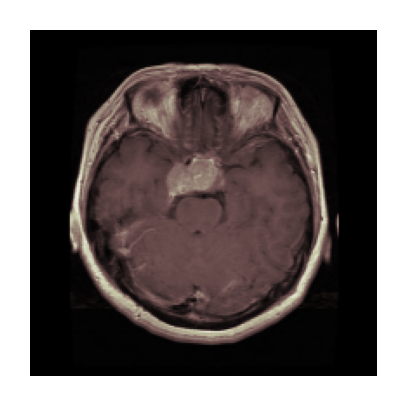

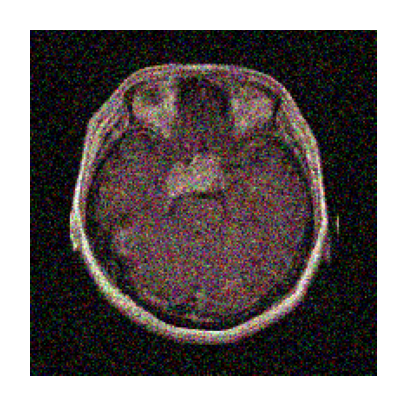

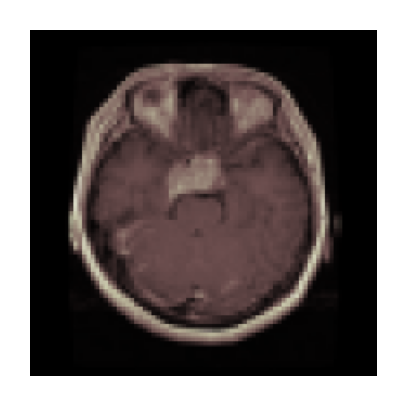

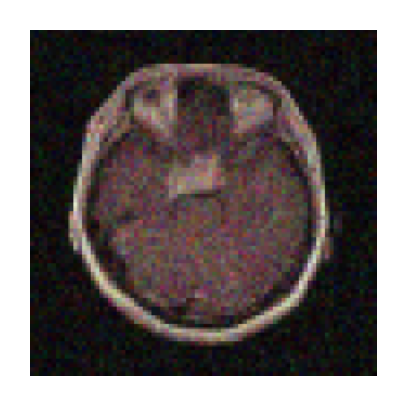

1/1 [==============================] - 0s 185ms/step


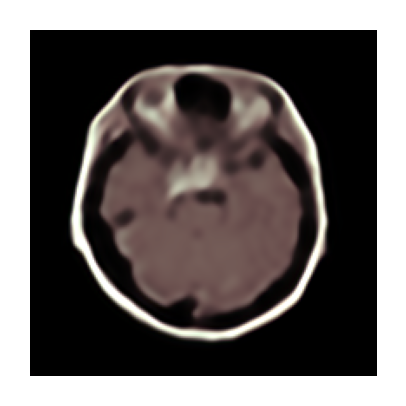

1/1 [==============================] - 0s 178ms/step


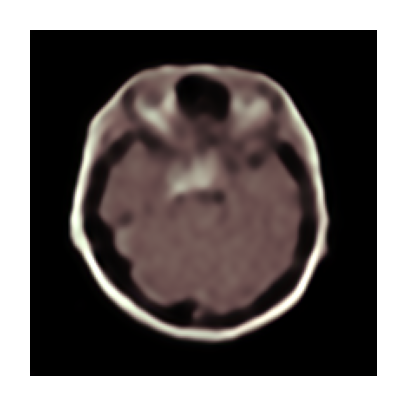

In [ ]:
'''
Selects an images and performs all the steps that are involved in the preprocessing technique to show visualisation.
image_all_steps variable take the image to show all setps
'''

import os
if not os.path.exists(save_images):
  # If the directory doesn't exist, create it
  os.makedirs(save_images)

#Image
image_all_steps = x_train[0]
# Set the DPI for your target resolution
dpi = 300

# Convert 10 points to inches (1 point = 1/72 inches)
height_in_inches = 1.5
width_in_inches = height_in_inches  # Making a square image for simplicity

fig = plt.figure(figsize=(width_in_inches, height_in_inches), dpi=dpi)
plt.imshow(image_all_steps)
plt.axis('off')
plt.show()
fig.savefig(f'{save_images}/orginal_image.png', bbox_inches='tight')

fig = plt.figure(figsize=(width_in_inches, height_in_inches), dpi=dpi)
plt.imshow(noise_image(image_all_steps))
plt.axis('off')
plt.show()
fig.savefig(f'{save_images}/noise_image.png', bbox_inches='tight')

fig = plt.figure(figsize=(width_in_inches, height_in_inches), dpi=dpi)
plt.imshow(pixalate_image(image_all_steps))
plt.axis('off')
plt.show()
fig.savefig(f'{save_images}/blur_image.png', bbox_inches='tight')


fig = plt.figure(figsize=(width_in_inches, height_in_inches), dpi=dpi)
plt.imshow(pre_data(image_all_steps))
plt.axis('off')
plt.show()
fig.savefig(f'{save_images}/noise_blur_image.png', bbox_inches='tight')

# This adds the batch dimension and later removes
image_deblur_denoise = denoise_and_deblur_images(np.expand_dims(image_all_steps, axis=0), deblur_path, denoise_path)
image_deblur_denoise = np.squeeze(image_deblur_denoise)

fig = plt.figure(figsize=(width_in_inches, height_in_inches), dpi=dpi)
plt.imshow(image_deblur_denoise)
plt.axis('off')
plt.show()
fig.savefig(f'{save_images}/de_noise_blur_orginal_image.png', bbox_inches='tight')

# This adds the batch dimension and later removes
image_deblur_denoise = denoise_and_deblur_images(np.expand_dims(pre_data(image_all_steps), axis=0), deblur_path, denoise_path)
image_deblur_denoise = np.squeeze(image_deblur_denoise)

fig = plt.figure(figsize=(width_in_inches, height_in_inches), dpi=dpi)
plt.imshow(image_deblur_denoise)
plt.axis('off')
plt.show()
fig.savefig(f'{save_images}/de_noise_blur_prep_image.png', bbox_inches='tight')

In [ ]:
'''
Apply preprocessing to a subset of the training data
Preprocessing means adding blur and noise to a percentage of images which is defined by varying_noisy_data_amount
gerneates a real world dataset
'''

indices_to_preprocess = np.random.choice(range(x_train.shape[0]), size=int(varying_noisy_data_amount * x_train.shape[0]), replace=False)
x_train_preprocessed = x_train.copy()
x_train_preprocessed[indices_to_preprocess] = preprocess_dataset(x_train[indices_to_preprocess])


In [ ]:
'''
Apply preprocessing to a subset of the val data
Preprocessing means adding blur and noise to a percentage of images which is defined by varying_noisy_data_amount
gerneates a real world dataset
'''
indices_to_preprocess = np.random.choice(range(x_val.shape[0]), size=int(varying_noisy_data_amount * x_val.shape[0]), replace=False)
x_val_preprocessed = x_val.copy()
x_val_preprocessed[indices_to_preprocess] = preprocess_dataset(x_val[indices_to_preprocess])

In [ ]:
'''
Apply preprocessing to a subset of the test data
Preprocessing means adding blur and noise to a percentage of images which is defined by varying_noisy_data_amount
gerneates a real world dataset
'''
indices_to_preprocess = np.random.choice(range(x_test.shape[0]), size=int(varying_noisy_data_amount * x_test.shape[0]), replace=False)
x_test_preprocessed = x_test.copy()
x_test_preprocessed[indices_to_preprocess] = preprocess_dataset(x_test[indices_to_preprocess])


In [ ]:
'''
Calling denoise_and_deblur_images funciton with the required params to get processed images
which can be used for trianing, validation and testing
'''

x_train_preprocessed_denoised_deblurred = denoise_and_deblur_images(
    x_train_preprocessed,
    deblur_path,
    denoise_path
)

x_val_preprocessed_denoised_deblurred = denoise_and_deblur_images(
    x_val_preprocessed,  # If you're preprocessing validation data similarly
    deblur_path,
    denoise_path
)

x_test_preprocessed_denoised_deblurred = denoise_and_deblur_images(
    x_test_preprocessed,  # If you're preprocessing validation data similarly
    deblur_path,
    denoise_path
)

143/143 [==============================] - 16s 109ms/step


KeyboardInterrupt: 

In [ ]:
'''
Saving the real world dataset after all the processing of encoders
'''

import numpy as np
np.savez_compressed(real_world_dataset_path,
                    x_train=x_train_preprocessed_denoised_deblurred, y_train=y_train,
                    x_test=x_test_preprocessed_denoised_deblurred, y_test=y_test,
                    x_val=x_val_preprocessed_denoised_deblurred, y_val=y_val)

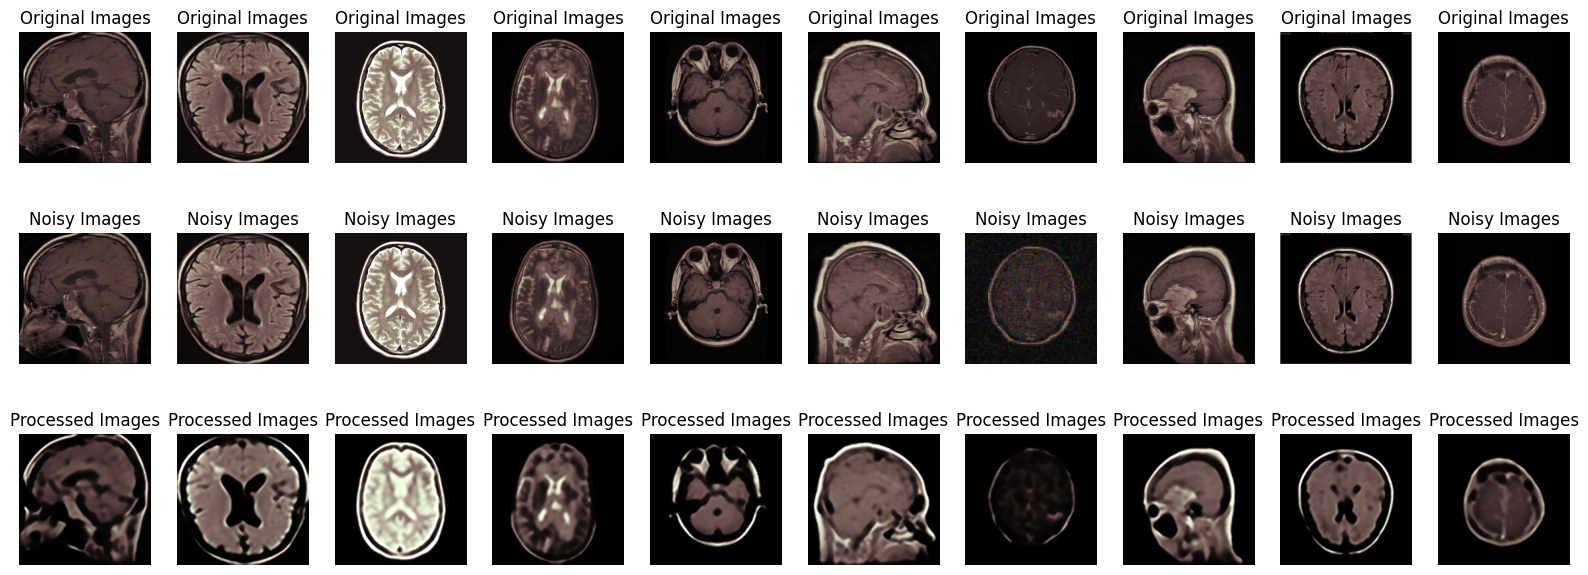

In [ ]:
'''
Function to compare how images changed over a the proessing methods steps
'''
import matplotlib.pyplot as plt


def visualize_images(original_noisy, denoised, deblurred, num_images=5):
    indices = np.random.choice(len(original_noisy), num_images, replace=False)

    plt.figure(figsize=(20, 10))

    for i, index in enumerate(indices):
        # Original Noisy Images
        plt.subplot(4, num_images, i + 1)
        plt.imshow(original_noisy[index])
        plt.title("Original Images")
        plt.axis('off')

        # Denoised Images
        plt.subplot(4, num_images, num_images + i + 1)
        plt.imshow(denoised[index])
        plt.title("Noisy Images")
        plt.axis('off')

        # Deblurred Images
        plt.subplot(4, num_images, 2 * num_images + i + 1)
        plt.imshow(deblurred[index])
        plt.title("Processed Images")
        plt.axis('off')

    plt.show()

# Call the function with your datasets
# Replace the variables with your actual data arrays if necessary
visualize_images(x_train, x_train_preprocessed, x_train_preprocessed_denoised_deblurred, num_images=10)

Custom model implementation

In [ ]:
def spatial_attention_module(x, return_attention=False):
    # Average Pooling
    x1 = tf.reduce_mean(x, axis=-1, keepdims=True)
    # Max Pooling
    x2 = tf.reduce_max(x, axis=-1, keepdims=True)
    # Concatenate both the features for feature map
    feats = tf.concat([x1, x2], axis=-1)
    # Conv layer
    attention_weights = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    modified_feats = tf.multiply(x, attention_weights)

    if return_attention:
        return modified_feats, attention_weights
    else:
        return modified_feats


In [ ]:
import matplotlib.pyplot as plt

def visualize_attention(input_image):
    # Assuming input_image is preprocessed and ready to be fed into the model
    # Make sure to expand dimensions if your model expects a batch
    input_image_batch = tf.expand_dims(input_image, axis=0)

    # Get the modified output and attention weights
    _, attention_weights = spatial_attention_module(input_image_batch, return_attention=True)

    # Squeeze to remove batch dimension and any singleton dimensions
    attention_weights = tf.squeeze(attention_weights)

    return attention_weights

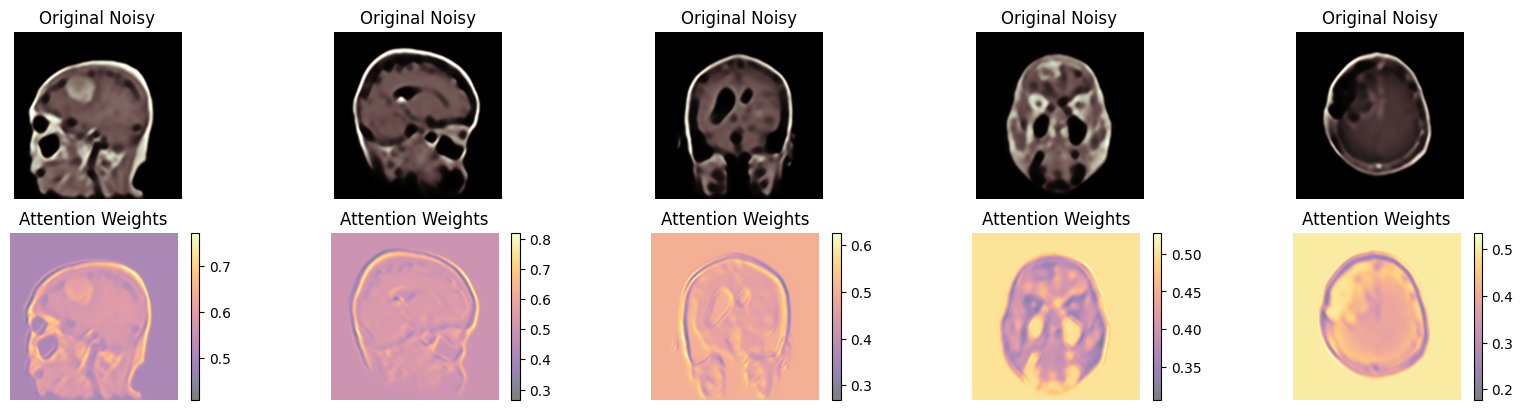

In [ ]:
num_images = 5
indices = np.random.choice(x_train_preprocessed_denoised_deblurred.shape[0], num_images, replace=False)
plt.figure(figsize=(20, 10))
for i, index in enumerate(indices):
  input_image = x_train_preprocessed_denoised_deblurred[index]
  # Original Noisy Images
  plt.subplot(4, num_images, i + 1)
  plt.imshow(input_image)
  plt.title("Original Noisy")
  plt.axis('off')

    # Denoised Images
  plt.subplot(4, num_images, num_images + i + 1)
  plt.imshow(visualize_attention(input_image), cmap='inferno', alpha=0.5)
  plt.colorbar()  # Adds a colorbar to match colors with values
  plt.title("Attention Weights")
  plt.axis('off')

In [ ]:
def create_cnn_with_spatial_attention(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # CNN
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Spatial Attention
    x = spatial_attention_module(x)


    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)


    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
input_shape = (200, 200, 3)
num_classes = 4
model = create_cnn_with_spatial_attention(input_shape, num_classes)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 200, 200, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 200, 200, 32)         128       ['conv2d_5[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)         0         ['batch_normalization[0][0

In [ ]:
from keras.optimizers import Adam
model.compile(optimizer= Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0)
model_checkpoint = ModelCheckpoint(best_cnn_model_path + 'best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)


In [ ]:
history = model.fit(x_train_preprocessed_denoised_deblurred, y_train,
                    batch_size=20,
                    epochs=50,
                    validation_data=(x_val_preprocessed_denoised_deblurred, y_val),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/50
229/229 [==============================] - ETA: 0s - loss: 0.9842 - accuracy: 0.7131
Epoch 1: val_loss improved from inf to 3.91659, saving model to /content/drive/MyDrive/Master_Project/Models/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 32s 116ms/step - loss: 0.9842 - accuracy: 0.7131 - val_loss: 3.9166 - val_accuracy: 0.3998 - lr: 0.0010
Epoch 2/50
228/229 [============================>.] - ETA: 0s - loss: 0.5136 - accuracy: 0.8020
Epoch 2: val_loss improved from 3.91659 to 0.43141, saving model to /content/drive/MyDrive/Master_Project/Models/best_model.h5
229/229 [==============================] - 5s 20ms/step - loss: 0.5132 - accuracy: 0.8021 - val_loss: 0.4314 - val_accuracy: 0.8285 - lr: 0.0010
Epoch 3/50
229/229 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.8453
Epoch 3: val_loss improved from 0.43141 to 0.40581, saving model to /content/drive/MyDrive/Master_Project/Models/best_model.h5
229/229 [==============================] - 5s 20ms/step - loss: 0.3924 - accuracy: 0.8453 - val_loss: 0.4058 - val_accuracy: 0.8364 - lr: 0.0010
Epoch 4/50
229/229 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.8838
Epoch 4: val_loss imp

In [ ]:
test_loss, test_acc = model.evaluate(x_test_preprocessed_denoised_deblurred, y_test)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

41/41 [==============================] - 1s 14ms/step - loss: 0.2720 - accuracy: 0.9314
Test accuracy: 0.9313501119613647
Test loss: 0.27199092507362366
